Davin Edbert Santoso Halim
/ 2602067086

# NOMER 3.a
a. [LO 1, LO 2, LO 3, 5 poin] **Jelaskan cara kerja dari arsitektur tersebut yang dideskripsikan dalam gambar di bawah ini:**

1. **Generator:**
- Generator adalah bagian nerural network yang membuat data palsu yang menyerupai data asli.
- Input dari generator adalah random noise (biasanya random vektor).
- Generator belajar untuk mengubah noise acak tersebut menjadi gambar yang terlihat nyata. Dalam gambar, ini diwakili oleh blok biru di sisi kiri.

2. **Discriminator:**
- Discriminator adalah neural network untuk membedakan antara data asli (dari set pelatihan) dan data palsu (dari generator).
- Discriminator menerima gambar dan menentukan apakah gambar tersebut asli atau palsu.(Dalam gambar, ini diwakili oleh blok merah di sisi kanan.)

3. **Training Set:**
- Training set terdiri dari data asli yang digunakan untuk melatih discriminator. Data ini memberikan contoh nyata yang harus ditiru oleh generator. (Dalam gambar, ini diwakili oleh tumpukan gambar di atas.)

4. **Proses Training:**
- Generator dan discriminator dilatih secara bersamaan dalam sebuah proses adversarial (berlawanan).
- Langkah-langkahnya adalah sebagai berikut:
- - Generator menghasilkan gambar palsu dari random noise.
- - Gambar palsu ini, bersama dengan gambar asli dari training set, diberikan kepada discriminator.
- - Discriminator mencoba membedakan antara gambar asli dan gambar palsu.
Generator diperbarui berdasarkan seberapa baik gambar palsu yang dihasilkan bisa menipu discriminator.
- - Discriminator diperbarui berdasarkan seberapa baik ia dapat membedakan gambar asli dari gambar palsu.
5. **Tujuan Akhir:**
- Generator ingin membuat gambar yang begitu nyata sehingga discriminator tidak bisa membedakannya dari gambar asli.
- Discriminator ingin semakin pintar dalam membedakan gambar asli dan gambar palsu.

Dalam proses ini, generator dan discriminator saling berkompetisi, yang pada akhirnya meningkatkan kemampuan keduanya: generator menjadi lebih baik dalam menghasilkan gambar realistis, dan discriminator menjadi lebih baik dalam mendeteksi gambar palsu.

# 3B

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

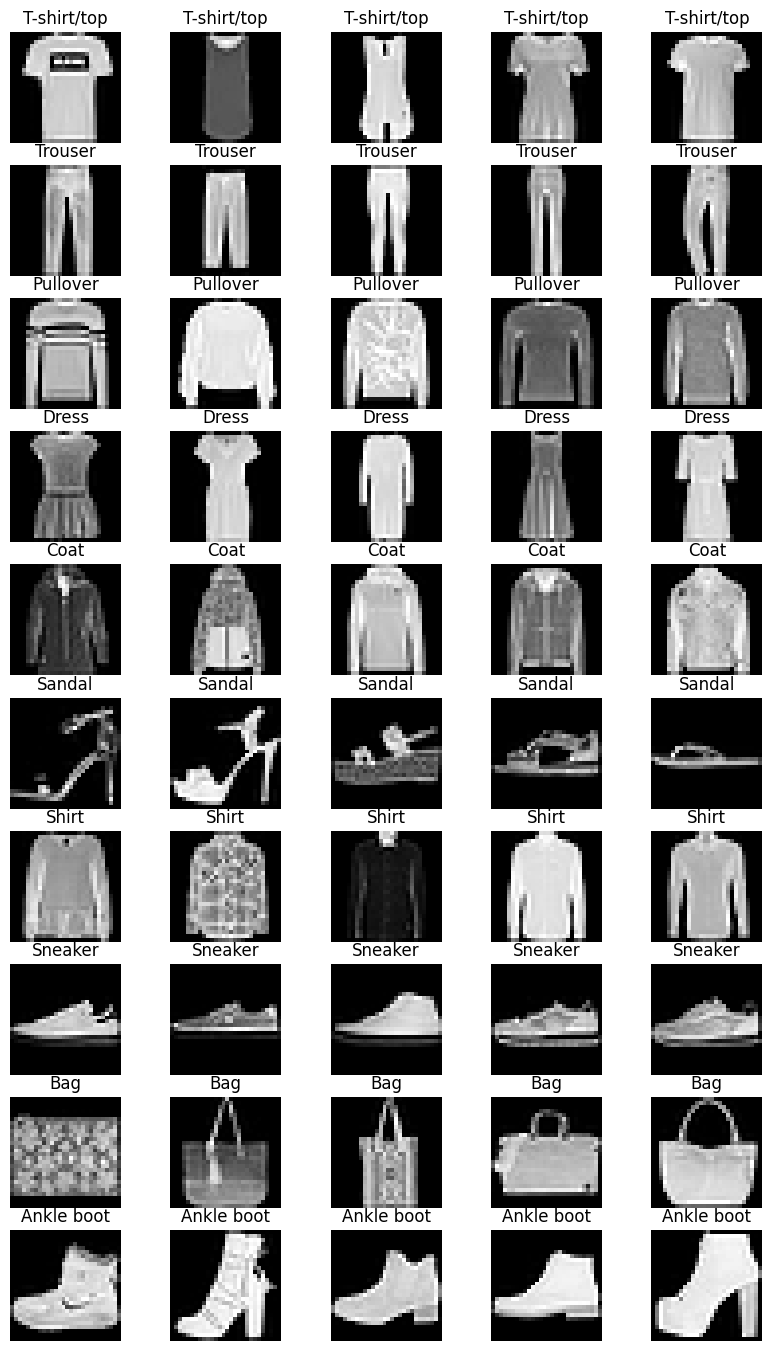

In [ ]:
plt.figure(figsize=(10, 17))
num_images_per_class = 5  # Jumlah gambar per kelas
for class_id in range(10):
    class_indices = np.where(train_labels == class_id)[0]
    for i in range(num_images_per_class):
        plt.subplot(10, num_images_per_class, class_id * num_images_per_class + i + 1)
        plt.imshow(train_images[class_indices[i]], cmap='gray')
        plt.title(class_names[class_id])
        plt.axis('off')

plt.show()

In [ ]:
print(f'Jumlah train img: {train_images.shape[0]}')
print(f'Jumlah test img: {test_images.shape[0]}')

Jumlah train img: 60000
Jumlah test img: 10000


In [ ]:
# Mengambil hanya kelas T-shirt/top (0) dan Trouser (1)
selected_train_indices = np.where((train_labels == 0) | (train_labels == 1))
selected_test_indices = np.where((test_labels == 0) | (test_labels == 1))

train_images_selected = train_images[selected_train_indices]
train_labels_selected = train_labels[selected_train_indices]
test_images_selected = test_images[selected_test_indices]
test_labels_selected = test_labels[selected_test_indices]

In [ ]:
print(f"Train images shape (selected): {train_images_selected.shape}")
print(f"Train labels shape (selected): {train_labels_selected.shape}")
print(f"Test images shape (selected): {test_images_selected.shape}")
print(f"Test labels shape (selected): {test_labels_selected.shape}")

Train images shape (selected): (12000, 28, 28)
Train labels shape (selected): (12000,)
Test images shape (selected): (2000, 28, 28)
Test labels shape (selected): (2000,)


In [ ]:
print(f'Jumlah train img: {train_images_selected.shape[0]}')
print(f'Jumlah test img: {test_images_selected.shape[0]}')

Jumlah train img: 12000
Jumlah test img: 2000


In [ ]:
# Mengubah label menjadi teks
label_names = {0: 'T-shirt/top', 1: 'Trouser'}
train_labels_selected_text = np.vectorize(label_names.get)(train_labels_selected)
test_labels_selected_text = np.vectorize(label_names.get)(test_labels_selected)

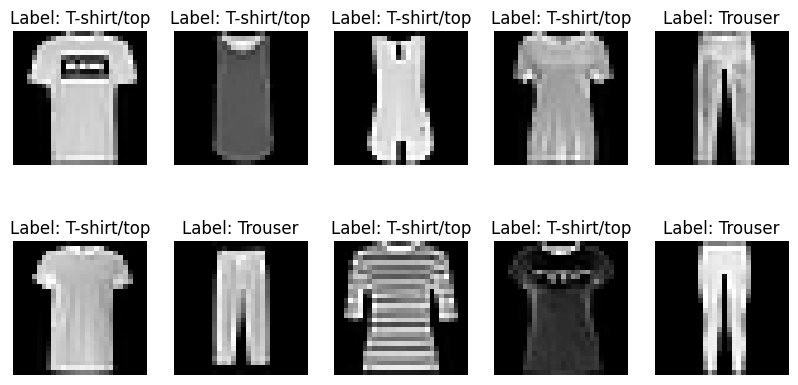

In [ ]:
# Menampilkan contoh data
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_selected[i], cmap='gray')
    plt.title(f'Label: {train_labels_selected_text[i]}')
    plt.axis('off')
plt.show()

In [ ]:
train_images_selected = train_images_selected.astype('float32') / 255.0
test_images_selected = test_images_selected.astype('float32') / 255.0

train_images_selected = np.expand_dims(train_images_selected, -1)
test_images_selected = np.expand_dims(test_images_selected, -1)

Normalisasi Data:
- Tujuan: Mengubah tipe data gambar menjadi float32 dan menormalisasi nilai piksel dari rentang [0, 255] menjadi [0, 1].
- Manfaat: Normalisasi penting untuk stabilitas pelatihan GAN karena jaringan neural cenderung berperforma lebih baik dengan input yang memiliki skala nilai yang lebih kecil dan seragam.

Penambahan Dimensi:
- Tujuan: Menambahkan satu dimensi tambahan ke array gambar, mengubah bentuknya dari (28, 28) menjadi (28, 28, 1).
- Manfaat: Banyak arsitektur jaringan convolutional, termasuk GAN, mengharapkan input dengan tiga dimensi (height, width, channels), bahkan jika gambar tersebut grayscale (memiliki satu channel). Ini memastikan data input sesuai dengan format yang diharapkan oleh model.

# MODELING

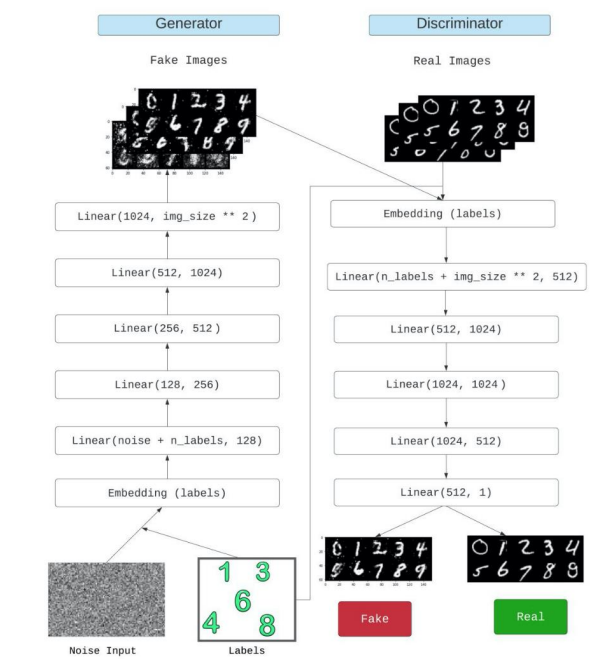

In [ ]:
# Define the generator
def build_generator(latent_dim, num_classes):
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(latent_dim + num_classes,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28 * 28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

Generator:
1. Input: Noise dan label yang digabungkan.
2. Lapisan:
- Dense Layers: 128, 256, 512, dan 1024 unit dengan aktivasi 'relu'.
- Output Layer: Dense layer dengan ukuran 28x28 dan aktivasi 'tanh'.
- Reshape Layer: Mengubah output menjadi bentuk gambar (28, 28, 1).
4. Output: Gambar palsu yang dihasilkan berdasarkan noise dan label.

Alasan Menggunakan ReLU:
1. Linearitas: ReLU adalah fungsi aktivasi linear untuk semua nilai positif, yang berarti outputnya proporsional terhadap inputnya (jika positif). Hal ini memudahkan jaringan neural untuk belajar dan mengoptimalkan bobot selama pelatihan.
2. Sederhana dan Efisien: ReLU adalah fungsi aktivasi yang sangat sederhana dan efisien. Ini hanya memerlukan operasi perbandingan sederhana untuk menghitung outputnya, yang membuat komputasi menjadi lebih cepat dibandingkan dengan fungsi aktivasi lain yang lebih kompleks.
3. Performa yang Lebih Baik dalam Praktek: ReLU telah terbukti bekerja sangat baik dalam praktek, terutama untuk jaringan deep learning. Banyak penelitian menunjukkan bahwa menggunakan ReLU dapat menghasilkan konvergensi yang lebih cepat dan performa yang lebih baik dibandingkan fungsi aktivasi lainnya.

In [ ]:
# Define the discriminator
def build_discriminator(num_classes):
    img_size = 28 * 28
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(img_size + num_classes,)))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Discriminator:
1. Input: Gambar (real atau palsu) dan label yang digabungkan.
2. Lapisan:
- Dense Layers: 512 dan 1024 unit dengan aktivasi 'leaky_relu'.
- Output Layer: Dense layer dengan 1 unit dan aktivasi 'sigmoid'.
3. Output: Skor yang menunjukkan apakah gambar adalah asli atau palsu.

Alasan Menggunakan Leaky ReLU?
1. Fleksibilitas Linear: Linearitas Leaky ReLU dengan slope kecil untuk nilai negatif memberikan fleksibilitas tambahan dalam proses pembelajaran, memungkinkan jaringan untuk menangkap pola yang lebih kompleks dalam data.
2. Meningkatkan Gradien: Dalam jaringan deep learning, gradien yang lebih besar membantu dalam pembaruan bobot yang lebih efektif selama pelatihan. Leaky ReLU memastikan bahwa gradien tetap mengalir untuk nilai negatif, sehingga membantu dalam stabilitas dan kecepatan konvergensi model.
3. Efisiensi Komputasi: Seperti ReLU, Leaky ReLU adalah fungsi aktivasi yang sangat sederhana dan efisien secara komputasi. Ini hanya memerlukan operasi perbandingan dan perkalian sederhana, yang membuatnya cepat dihitung.

In [ ]:
# Combine noise and labels
def combine_noise_and_labels(noise, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    return tf.concat([noise, label_embedding], axis=1)

Tujuan: Menggabungkan noise dengan embedding dari label untuk input ke generator.


In [ ]:
# Combine images and labels
def combine_images_and_labels(images, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    images_flatten = tf.reshape(images, [images.shape[0], -1])
    return tf.concat([images_flatten, label_embedding], axis=1)

Tujuan: Menggabungkan gambar dengan embedding dari label untuk input ke discriminator.


In [ ]:
latent_dim = 100
num_classes = 2

In [ ]:
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)

In [ ]:
# Optimizers
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Menggunakan Adam optimizer untuk generator (optimizer_G) dan discriminator (optimizer_D) dengan learning rate 0.0002 dan beta_1 0.5.

In [ ]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

Loss Function: Binary Crossentropy digunakan sebagai fungsi loss untuk mengukur perbedaan antara prediksi dan label nyata.

In [ ]:
@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    fake_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)

    fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes))

    combined_labels = tf.concat([tf.cast(real_labels, tf.int32), fake_labels], axis=0)
    combined_images = tf.concat([real_images, fake_images], axis=0)

    # Combine images and labels for discriminator
    real_images_with_labels = combine_images_and_labels(real_images, tf.cast(real_labels, tf.int32), num_classes)
    fake_images_with_labels = combine_images_and_labels(fake_images, fake_labels, num_classes)
    combined_images_with_labels = tf.concat([real_images_with_labels, fake_images_with_labels], axis=0)

    # Discriminator training
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images_with_labels, training=True)
        fake_output = discriminator(fake_images_with_labels, training=True)

        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer_D.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Generator training
    noise = tf.random.normal([batch_size, latent_dim])
    misleading_labels = tf.ones([batch_size, 1])

    with tf.GradientTape() as tape:
        fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes), training=True)
        fake_output = discriminator(combine_images_and_labels(fake_images, fake_labels, num_classes), training=True)

        g_loss = cross_entropy(misleading_labels, fake_output)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(grads, generator.trainable_variables))

    return d_loss, g_loss

1. Inisialisasi dan Pembuatan Gambar Palsu
- batch_size: Mendapatkan ukuran batch dari real_images.
- noise: Membuat noise acak dengan dimensi [batch_size, latent_dim].
- fake_labels: Membuat label acak untuk gambar palsu dengan nilai antara 0 dan - num_classes.
- fake_images: Generator menggunakan noise dan label palsu yang digabungkan untuk menghasilkan gambar palsu.

2. Menggabungkan Data Nyata dan Palsu
- combined_labels: Menggabungkan label nyata dan palsu menjadi satu tensor.
- combined_images: Menggabungkan gambar nyata dan palsu menjadi satu tensor.

3. Menggabungkan Gambar dan Label untuk Discriminator
real_images_with_labels: Menggabungkan gambar nyata dan label untuk input ke discriminator.
fake_images_with_labels: Menggabungkan gambar palsu dan label untuk input ke discriminator.
combined_images_with_labels: Menggabungkan input gambar nyata dan palsu untuk pelatihan discriminator.

4. Pelatihan Discriminator
- GradientTape: Merekam operasi untuk menghitung gradien.
- real_output dan fake_output: Discriminator memberikan prediksi untuk gambar nyata dan palsu.
- d_loss_real: Loss untuk gambar nyata (target: 1).
- d_loss_fake: Loss untuk gambar palsu (target: 0).
- d_loss: Total loss untuk discriminator.
- grads: Menghitung gradien untuk parameter discriminator.
- apply_gradients: Memperbarui bobot discriminator dengan gradien yang dihitung.

5. Pelatihan Generator
- noise: Membuat noise acak baru untuk pelatihan generator.
- misleading_labels: Label target untuk gambar palsu (semua 1), karena generator ingin menipu discriminator agar menganggap gambar palsu sebagai nyata.
- GradientTape: Merekam operasi untuk menghitung gradien.
- fake_images: Generator menghasilkan gambar palsu baru.
- fake_output: Discriminator memberikan prediksi untuk gambar palsu yang baru dihasilkan.
- g_loss: Loss untuk generator, berdasarkan seberapa baik gambar palsu menipu discriminator (target: 1).
- grads: Menghitung gradien untuk parameter generator.
apply_gradients: Memperbarui bobot generator dengan gradien yang dihitung

In [ ]:
def display_images(generator, noise, labels, epoch, num_examples=5):
    generated_images = generator.predict(combine_noise_and_labels(noise, labels, num_classes), verbose=0)
    generated_images = (generated_images + 1) / 2.0  # Scaling to [0, 1]

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

Menampilkan gambar yang dihasilkan oleh generator setiap interval tertentu.

In [ ]:
# Training loop
def train(dataset, epochs, save_interval=5):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            d_loss, g_loss = train_step(image_batch, label_batch)

        print(f'Epoch {epoch+1}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}')

        if (epoch + 1) % save_interval == 0:
            # Display gambar
            noise = np.random.normal(0, 1, (5, latent_dim))
            labels = np.random.randint(0, num_classes, 5)
            display_images(generator, noise, labels, epoch + 1)

In [ ]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_selected, train_labels_selected))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

- tf.data.Dataset.from_tensor_slices: Fungsi ini membuat objek tf.data.Dataset dari tensor yang diberikan. Ini memungkinkan dataset untuk diproses dalam bentuk batch dan diacak.
- shuffle(buffer_size=1024): Mengacak dataset sebelum membaginya menjadi batch. buffer_size menentukan ukuran buffer untuk pengacakan. Buffer dengan ukuran 1024 berarti 1024 contoh data pertama diacak sebelum pengacakan berikutnya. Ini membantu dalam membuat data yang diumpankan ke model tidak terurut, yang penting untuk menghindari bias selama pelatihan.
- batch(batch_size): Membagi dataset yang telah diacak menjadi batch dengan ukuran yang ditentukan (batch_size). Dalam hal ini, ukuran batch adalah 64.

Epoch 1, D Loss: 0.6379744410514832, G Loss: 2.773190498352051
Epoch 2, D Loss: 0.7039011716842651, G Loss: 2.3246123790740967
Epoch 3, D Loss: 0.9562605023384094, G Loss: 3.598872184753418
Epoch 4, D Loss: 0.9075984358787537, G Loss: 2.6260194778442383
Epoch 5, D Loss: 0.8241265416145325, G Loss: 1.2992808818817139


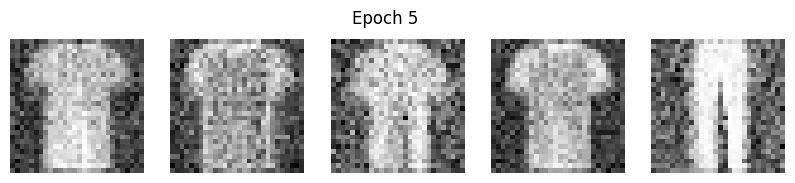

Epoch 6, D Loss: 1.4470280408859253, G Loss: 0.8378258943557739
Epoch 7, D Loss: 1.0839991569519043, G Loss: 1.8814704418182373
Epoch 8, D Loss: 0.9319779872894287, G Loss: 1.7119733095169067
Epoch 9, D Loss: 1.1907644271850586, G Loss: 1.2798714637756348
Epoch 10, D Loss: 1.0478278398513794, G Loss: 1.2268486022949219


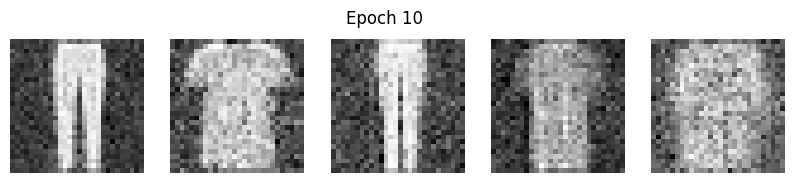

Epoch 11, D Loss: 1.1671298742294312, G Loss: 1.976697564125061
Epoch 12, D Loss: 1.029853105545044, G Loss: 1.4516160488128662
Epoch 13, D Loss: 1.2569482326507568, G Loss: 1.2011830806732178
Epoch 14, D Loss: 1.1325663328170776, G Loss: 1.0589072704315186
Epoch 15, D Loss: 1.3950886726379395, G Loss: 1.675330638885498


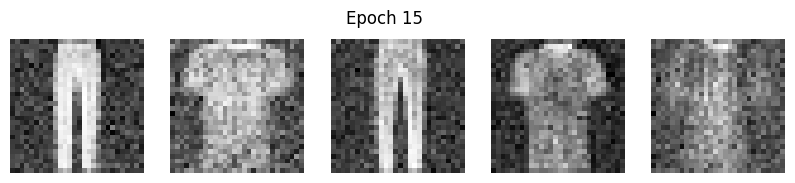

Epoch 16, D Loss: 1.0255435705184937, G Loss: 1.334646224975586
Epoch 17, D Loss: 1.1637439727783203, G Loss: 0.9344805479049683
Epoch 18, D Loss: 1.0528161525726318, G Loss: 1.4309734106063843
Epoch 19, D Loss: 1.1808151006698608, G Loss: 2.108391284942627
Epoch 20, D Loss: 1.0005759000778198, G Loss: 1.0065886974334717


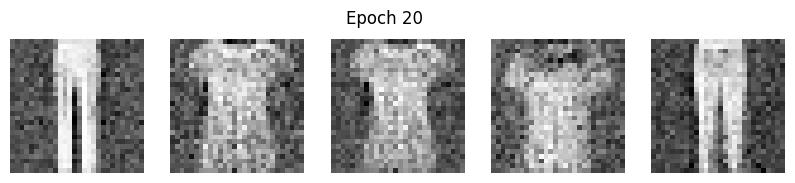

Epoch 21, D Loss: 1.1873269081115723, G Loss: 0.9366840124130249
Epoch 22, D Loss: 1.1841130256652832, G Loss: 1.6935462951660156
Epoch 23, D Loss: 1.3274980783462524, G Loss: 1.4008575677871704
Epoch 24, D Loss: 1.2617812156677246, G Loss: 1.355879545211792
Epoch 25, D Loss: 1.2131688594818115, G Loss: 0.9640976190567017


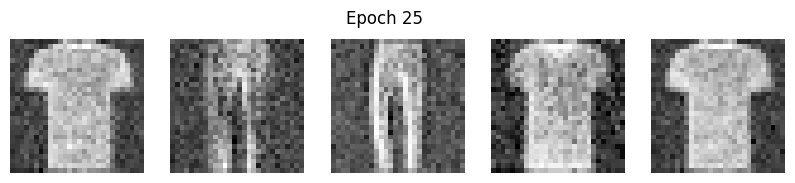

Epoch 26, D Loss: 1.143887996673584, G Loss: 1.2020738124847412
Epoch 27, D Loss: 1.1996828317642212, G Loss: 1.056776762008667
Epoch 28, D Loss: 1.3641676902770996, G Loss: 2.0710203647613525
Epoch 29, D Loss: 1.0328741073608398, G Loss: 1.661678671836853
Epoch 30, D Loss: 1.1236648559570312, G Loss: 1.3705518245697021


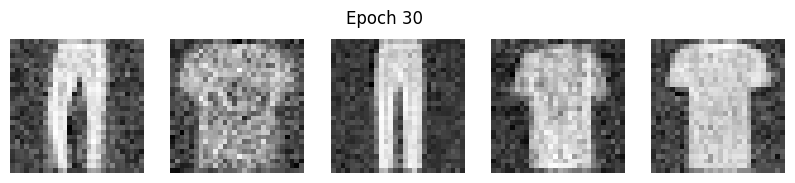

Epoch 31, D Loss: 1.1395567655563354, G Loss: 1.3887290954589844
Epoch 32, D Loss: 1.0912940502166748, G Loss: 1.1952505111694336
Epoch 33, D Loss: 1.1106579303741455, G Loss: 1.3472435474395752
Epoch 34, D Loss: 1.242485761642456, G Loss: 1.5615272521972656
Epoch 35, D Loss: 1.1867974996566772, G Loss: 1.1595933437347412


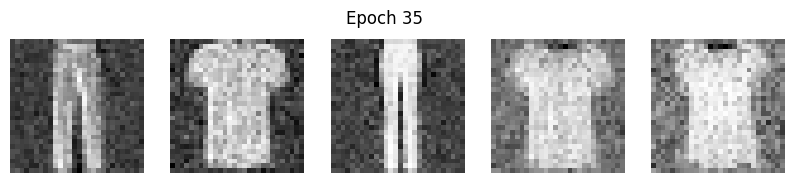

Epoch 36, D Loss: 1.0774281024932861, G Loss: 0.9695285558700562
Epoch 37, D Loss: 1.30208158493042, G Loss: 0.7594386339187622
Epoch 38, D Loss: 1.165123701095581, G Loss: 0.9940754771232605
Epoch 39, D Loss: 1.0247302055358887, G Loss: 0.8120534420013428
Epoch 40, D Loss: 1.1628785133361816, G Loss: 0.8637827038764954


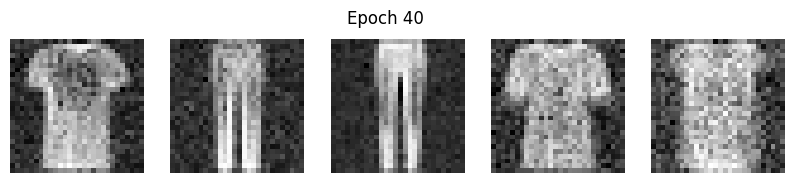

Epoch 41, D Loss: 1.1466606855392456, G Loss: 1.0108760595321655
Epoch 42, D Loss: 1.1945319175720215, G Loss: 1.1424000263214111
Epoch 43, D Loss: 1.334396243095398, G Loss: 1.5083439350128174
Epoch 44, D Loss: 1.2104566097259521, G Loss: 1.3766069412231445
Epoch 45, D Loss: 1.1194721460342407, G Loss: 1.00420081615448


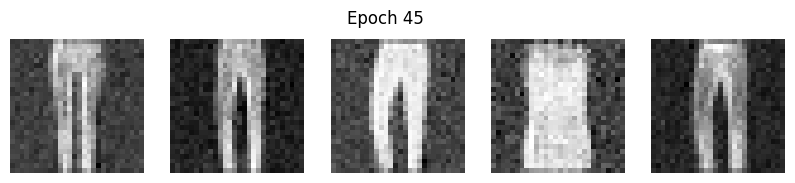

Epoch 46, D Loss: 1.2132549285888672, G Loss: 1.0506837368011475
Epoch 47, D Loss: 1.3174844980239868, G Loss: 0.9817925691604614
Epoch 48, D Loss: 1.2471914291381836, G Loss: 0.9041053652763367
Epoch 49, D Loss: 1.131304144859314, G Loss: 1.707697868347168
Epoch 50, D Loss: 1.1564579010009766, G Loss: 1.3317604064941406


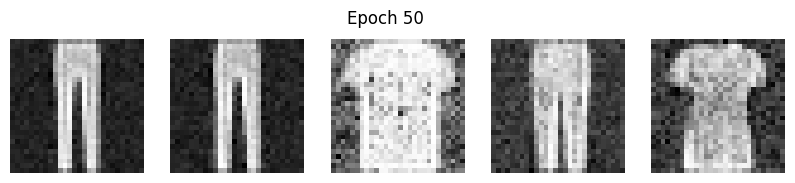

Epoch 51, D Loss: 1.2627677917480469, G Loss: 0.6468290090560913
Epoch 52, D Loss: 1.1130768060684204, G Loss: 1.415946364402771
Epoch 53, D Loss: 1.1417545080184937, G Loss: 1.0325199365615845
Epoch 54, D Loss: 1.1965391635894775, G Loss: 1.6263376474380493
Epoch 55, D Loss: 1.102165937423706, G Loss: 1.0616941452026367


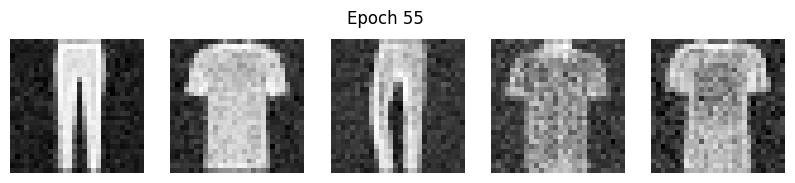

Epoch 56, D Loss: 1.1399471759796143, G Loss: 1.1899523735046387
Epoch 57, D Loss: 1.1712663173675537, G Loss: 0.9252578616142273
Epoch 58, D Loss: 1.0641043186187744, G Loss: 1.0847355127334595
Epoch 59, D Loss: 1.0402849912643433, G Loss: 1.5086796283721924
Epoch 60, D Loss: 1.2264983654022217, G Loss: 0.9273688793182373


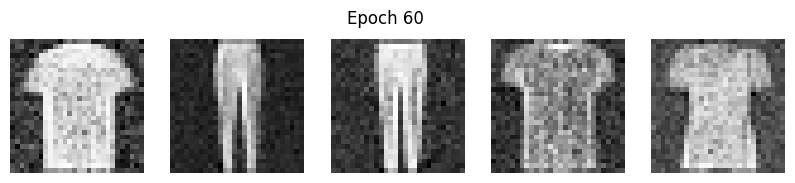

Epoch 61, D Loss: 1.0241621732711792, G Loss: 1.5494534969329834
Epoch 62, D Loss: 1.0787959098815918, G Loss: 1.3031927347183228
Epoch 63, D Loss: 1.2038772106170654, G Loss: 1.1666584014892578
Epoch 64, D Loss: 1.1208375692367554, G Loss: 1.0278021097183228
Epoch 65, D Loss: 1.3431942462921143, G Loss: 0.7361609935760498


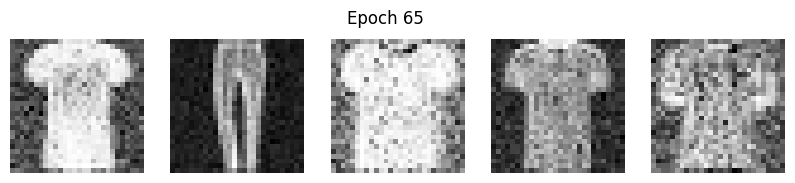

Epoch 66, D Loss: 1.1245524883270264, G Loss: 0.8201647996902466
Epoch 67, D Loss: 1.2989470958709717, G Loss: 1.4926238059997559
Epoch 68, D Loss: 1.1786290407180786, G Loss: 0.9151973724365234
Epoch 69, D Loss: 1.2714180946350098, G Loss: 1.4033876657485962
Epoch 70, D Loss: 1.141806721687317, G Loss: 1.0307731628417969


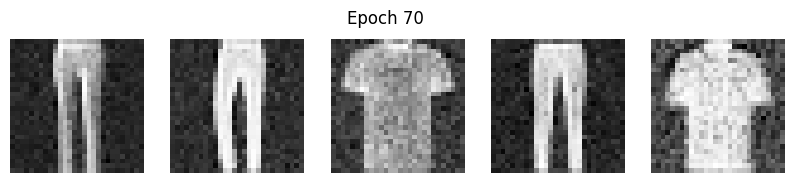

Epoch 71, D Loss: 1.2783334255218506, G Loss: 0.7170687913894653
Epoch 72, D Loss: 1.2068597078323364, G Loss: 0.990814208984375
Epoch 73, D Loss: 0.954565167427063, G Loss: 1.587419867515564
Epoch 74, D Loss: 1.0389280319213867, G Loss: 1.064132809638977
Epoch 75, D Loss: 1.1799795627593994, G Loss: 1.33670973777771


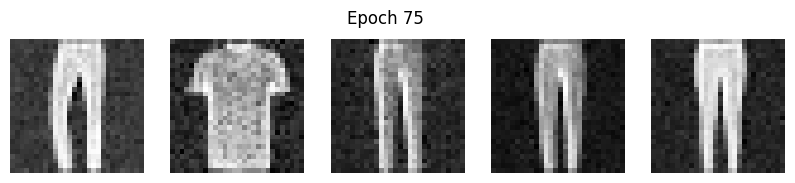

Epoch 76, D Loss: 0.9193814396858215, G Loss: 1.2434980869293213
Epoch 77, D Loss: 0.8987641334533691, G Loss: 1.344350814819336
Epoch 78, D Loss: 1.0522278547286987, G Loss: 1.1986360549926758
Epoch 79, D Loss: 1.0884101390838623, G Loss: 1.0858570337295532
Epoch 80, D Loss: 1.071283221244812, G Loss: 1.155930519104004


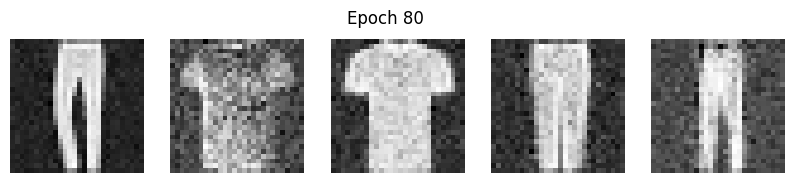

Epoch 81, D Loss: 1.133074402809143, G Loss: 1.306839108467102
Epoch 82, D Loss: 1.0684698820114136, G Loss: 1.2906138896942139
Epoch 83, D Loss: 1.114980936050415, G Loss: 1.0510250329971313
Epoch 84, D Loss: 1.115537166595459, G Loss: 1.1097311973571777
Epoch 85, D Loss: 1.090750813484192, G Loss: 1.6779544353485107


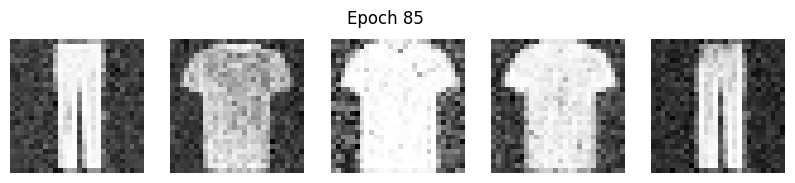

Epoch 86, D Loss: 1.1868668794631958, G Loss: 1.3522298336029053
Epoch 87, D Loss: 0.8926821351051331, G Loss: 1.2497408390045166
Epoch 88, D Loss: 0.9606360197067261, G Loss: 1.4493404626846313
Epoch 89, D Loss: 1.0634506940841675, G Loss: 1.6520256996154785
Epoch 90, D Loss: 1.277190923690796, G Loss: 1.1514337062835693


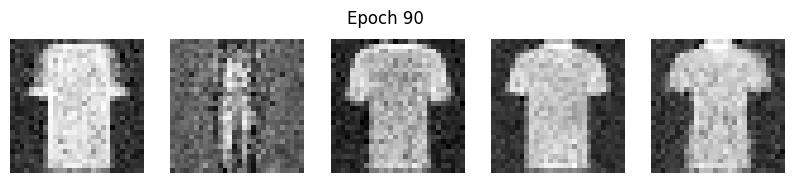

Epoch 91, D Loss: 1.2379473447799683, G Loss: 1.2765833139419556
Epoch 92, D Loss: 1.1627312898635864, G Loss: 1.0835716724395752
Epoch 93, D Loss: 0.9798874855041504, G Loss: 1.170569658279419
Epoch 94, D Loss: 1.1471644639968872, G Loss: 1.246891975402832
Epoch 95, D Loss: 0.9490104913711548, G Loss: 1.6300108432769775


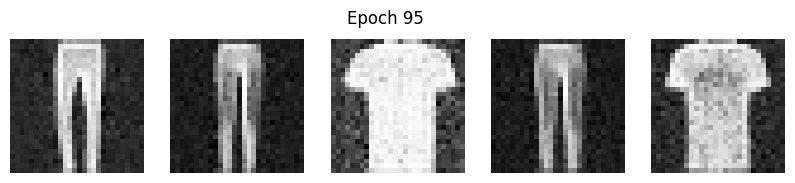

Epoch 96, D Loss: 0.9310628175735474, G Loss: 1.2238422632217407
Epoch 97, D Loss: 0.8758749961853027, G Loss: 1.557909369468689
Epoch 98, D Loss: 0.9921330213546753, G Loss: 1.2358603477478027
Epoch 99, D Loss: 0.973385214805603, G Loss: 1.4089778661727905
Epoch 100, D Loss: 1.0522277355194092, G Loss: 0.9606537818908691


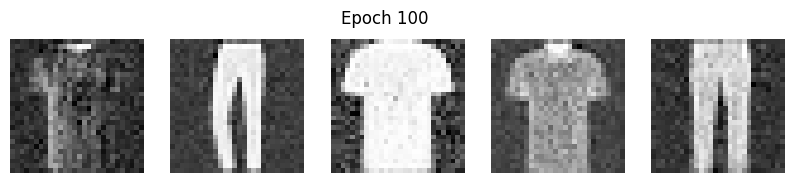

Epoch 101, D Loss: 0.8870193362236023, G Loss: 1.4594520330429077
Epoch 102, D Loss: 0.9380271434783936, G Loss: 1.2430534362792969
Epoch 103, D Loss: 1.0400558710098267, G Loss: 1.366645097732544
Epoch 104, D Loss: 1.0396465063095093, G Loss: 0.8170974850654602
Epoch 105, D Loss: 0.9607146978378296, G Loss: 1.5122106075286865


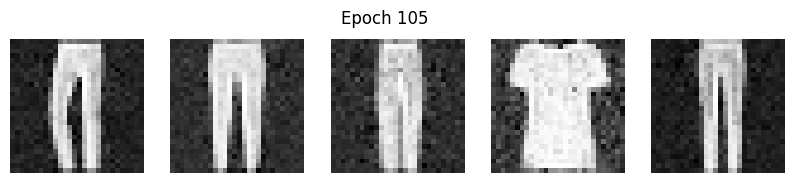

Epoch 106, D Loss: 1.0961471796035767, G Loss: 1.6766996383666992
Epoch 107, D Loss: 1.1351454257965088, G Loss: 1.2728444337844849
Epoch 108, D Loss: 0.764765739440918, G Loss: 1.3570793867111206
Epoch 109, D Loss: 1.238560438156128, G Loss: 1.3503024578094482
Epoch 110, D Loss: 0.9323263168334961, G Loss: 2.2183191776275635


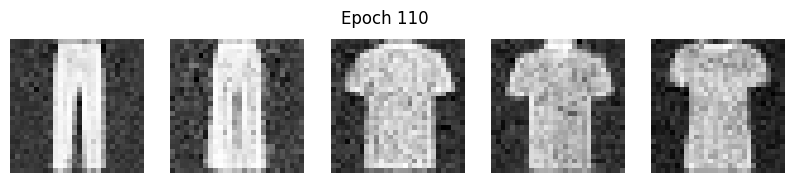

Epoch 111, D Loss: 0.829607367515564, G Loss: 1.605949878692627
Epoch 112, D Loss: 1.1063917875289917, G Loss: 1.426284670829773
Epoch 113, D Loss: 0.9811052083969116, G Loss: 1.2870920896530151
Epoch 114, D Loss: 0.9619962573051453, G Loss: 1.4086456298828125
Epoch 115, D Loss: 0.810722291469574, G Loss: 1.9282331466674805


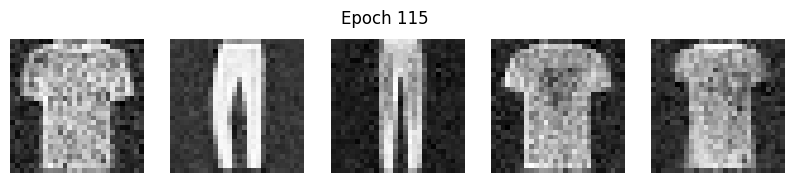

Epoch 116, D Loss: 0.6041505336761475, G Loss: 1.6322009563446045
Epoch 117, D Loss: 1.1446967124938965, G Loss: 1.3442442417144775
Epoch 118, D Loss: 0.8860812187194824, G Loss: 1.2692756652832031
Epoch 119, D Loss: 1.1033461093902588, G Loss: 1.145727515220642
Epoch 120, D Loss: 0.9944016933441162, G Loss: 1.3413811922073364


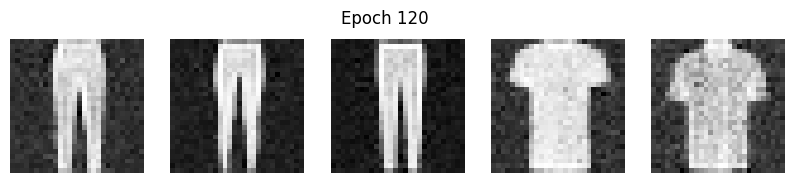

Epoch 121, D Loss: 0.8547763824462891, G Loss: 1.4496934413909912
Epoch 122, D Loss: 0.940322756767273, G Loss: 1.7981858253479004
Epoch 123, D Loss: 0.9467902183532715, G Loss: 1.9594993591308594
Epoch 124, D Loss: 0.8040366172790527, G Loss: 1.950905680656433
Epoch 125, D Loss: 0.7559592127799988, G Loss: 1.9044275283813477


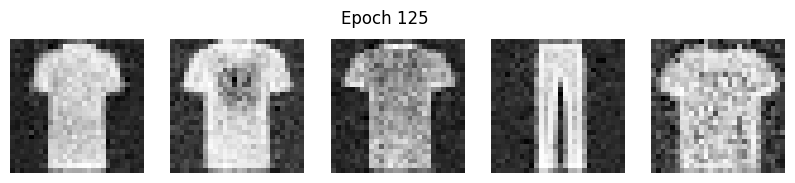

Epoch 126, D Loss: 0.8479950428009033, G Loss: 2.813845157623291
Epoch 127, D Loss: 0.6494777798652649, G Loss: 2.0759689807891846
Epoch 128, D Loss: 0.8013457655906677, G Loss: 1.8322296142578125
Epoch 129, D Loss: 0.684378445148468, G Loss: 2.066913366317749
Epoch 130, D Loss: 0.8455355167388916, G Loss: 1.7727971076965332


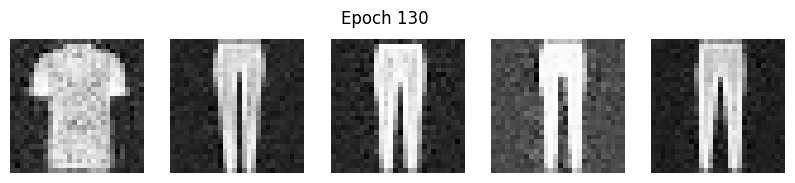

Epoch 131, D Loss: 0.9890083074569702, G Loss: 3.005974769592285
Epoch 132, D Loss: 0.8736745119094849, G Loss: 2.0856213569641113
Epoch 133, D Loss: 0.8691834211349487, G Loss: 1.582437515258789
Epoch 134, D Loss: 0.8795952796936035, G Loss: 2.03226900100708
Epoch 135, D Loss: 0.7473081350326538, G Loss: 1.8586267232894897


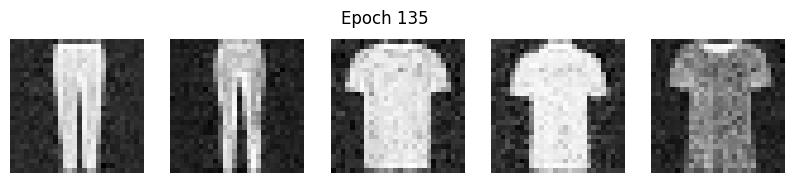

Epoch 136, D Loss: 1.4141520261764526, G Loss: 1.070473074913025
Epoch 137, D Loss: 1.1394903659820557, G Loss: 1.916089653968811
Epoch 138, D Loss: 0.7048899531364441, G Loss: 1.2807199954986572
Epoch 139, D Loss: 0.8249019384384155, G Loss: 2.3048157691955566
Epoch 140, D Loss: 0.8402763605117798, G Loss: 1.3522920608520508


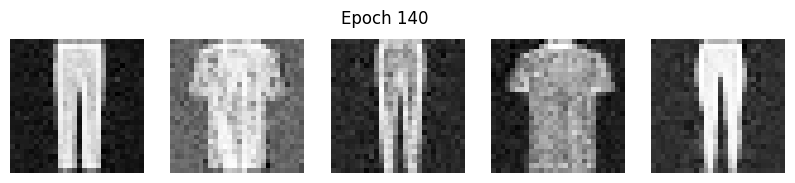

Epoch 141, D Loss: 0.8433606028556824, G Loss: 1.7082734107971191
Epoch 142, D Loss: 0.8361867666244507, G Loss: 1.7640184164047241
Epoch 143, D Loss: 0.8571668863296509, G Loss: 1.7912788391113281
Epoch 144, D Loss: 1.0107260942459106, G Loss: 2.518843412399292
Epoch 145, D Loss: 0.8465802669525146, G Loss: 1.6937580108642578


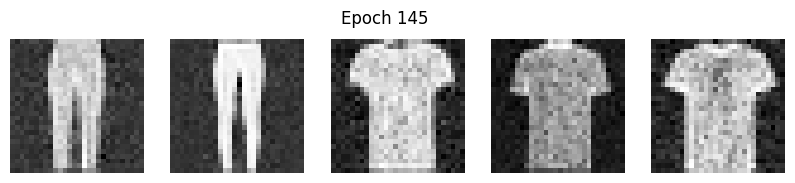

Epoch 146, D Loss: 0.9435883164405823, G Loss: 2.924856185913086
Epoch 147, D Loss: 0.856818675994873, G Loss: 1.5993921756744385
Epoch 148, D Loss: 0.7122563123703003, G Loss: 2.4076757431030273
Epoch 149, D Loss: 0.7362507581710815, G Loss: 1.8854761123657227
Epoch 150, D Loss: 0.8260788321495056, G Loss: 2.067689895629883


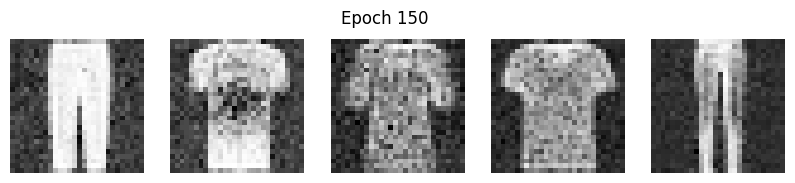

Epoch 151, D Loss: 0.5453122854232788, G Loss: 2.5949811935424805
Epoch 152, D Loss: 0.7829311490058899, G Loss: 1.3785158395767212
Epoch 153, D Loss: 0.6297023296356201, G Loss: 1.8995914459228516
Epoch 154, D Loss: 0.9157934784889221, G Loss: 3.0592145919799805
Epoch 155, D Loss: 0.6880265474319458, G Loss: 1.1675434112548828


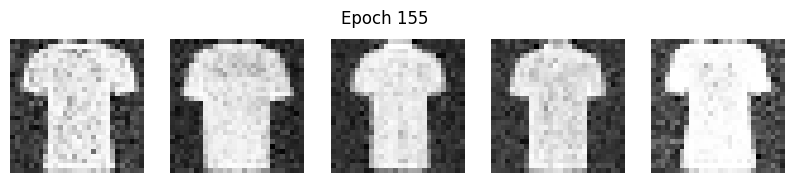

Epoch 156, D Loss: 0.6508277654647827, G Loss: 1.557481050491333
Epoch 157, D Loss: 0.6735657453536987, G Loss: 2.098466396331787
Epoch 158, D Loss: 0.5979650020599365, G Loss: 2.4513626098632812
Epoch 159, D Loss: 0.7714601755142212, G Loss: 2.136305332183838
Epoch 160, D Loss: 0.6595715284347534, G Loss: 2.1814188957214355


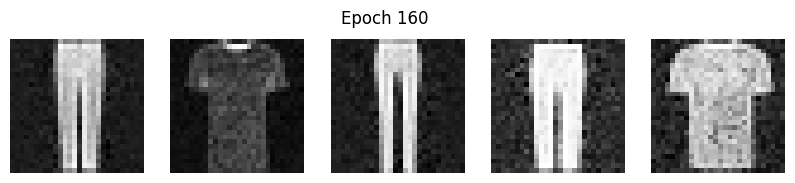

Epoch 161, D Loss: 0.7123531699180603, G Loss: 2.2950823307037354
Epoch 162, D Loss: 0.5775043964385986, G Loss: 1.6526168584823608
Epoch 163, D Loss: 0.8604964017868042, G Loss: 2.1200029850006104
Epoch 164, D Loss: 0.6592075824737549, G Loss: 2.4606547355651855
Epoch 165, D Loss: 0.6730175018310547, G Loss: 1.548774242401123


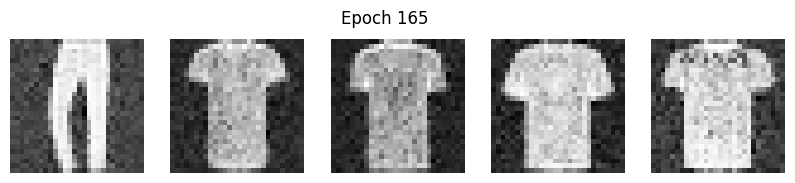

Epoch 166, D Loss: 0.7988953590393066, G Loss: 1.9740347862243652
Epoch 167, D Loss: 0.522680401802063, G Loss: 2.3806345462799072
Epoch 168, D Loss: 0.41956380009651184, G Loss: 2.3564648628234863
Epoch 169, D Loss: 0.6913981437683105, G Loss: 1.466273546218872
Epoch 170, D Loss: 0.47808393836021423, G Loss: 2.163271903991699


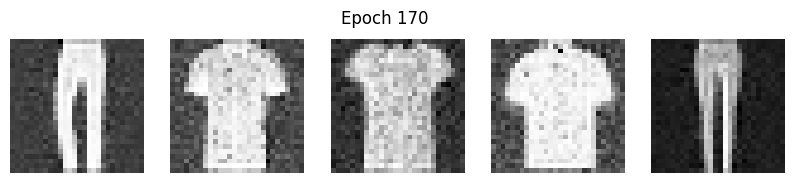

Epoch 171, D Loss: 0.8454228639602661, G Loss: 2.038367986679077
Epoch 172, D Loss: 1.0265300273895264, G Loss: 0.9532777070999146
Epoch 173, D Loss: 0.669438898563385, G Loss: 2.8592276573181152
Epoch 174, D Loss: 0.6395463943481445, G Loss: 3.128671646118164
Epoch 175, D Loss: 0.5492278933525085, G Loss: 3.6507010459899902


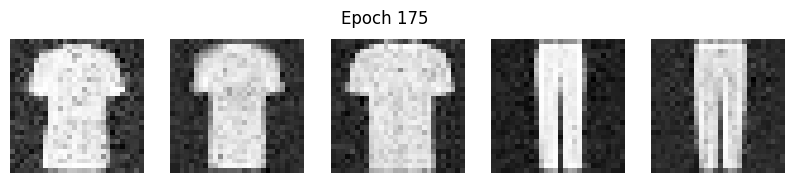

Epoch 176, D Loss: 0.5808042287826538, G Loss: 2.376732349395752
Epoch 177, D Loss: 0.659735918045044, G Loss: 2.0723254680633545
Epoch 178, D Loss: 0.5108146667480469, G Loss: 2.1935524940490723
Epoch 179, D Loss: 0.5937590599060059, G Loss: 1.7056442499160767
Epoch 180, D Loss: 0.5562587976455688, G Loss: 2.229609966278076


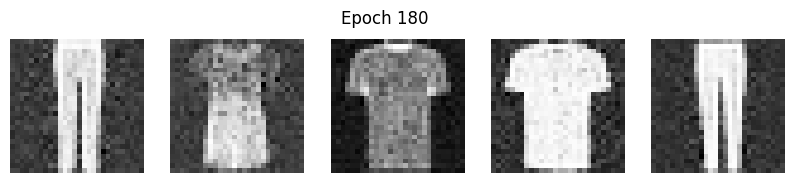

Epoch 181, D Loss: 0.7411289811134338, G Loss: 2.465392589569092
Epoch 182, D Loss: 0.5317596197128296, G Loss: 1.8905329704284668
Epoch 183, D Loss: 0.6641603708267212, G Loss: 3.2552599906921387
Epoch 184, D Loss: 0.7985216379165649, G Loss: 1.8988702297210693
Epoch 185, D Loss: 0.6805570721626282, G Loss: 3.552091598510742


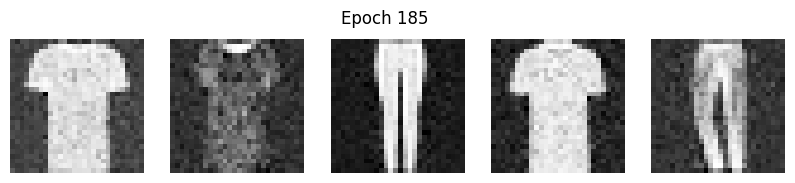

Epoch 186, D Loss: 0.5388699769973755, G Loss: 1.88716721534729
Epoch 187, D Loss: 0.5973830223083496, G Loss: 2.141084671020508
Epoch 188, D Loss: 0.651908814907074, G Loss: 2.442451000213623
Epoch 189, D Loss: 0.49484676122665405, G Loss: 2.480121612548828
Epoch 190, D Loss: 0.6298445463180542, G Loss: 1.4326483011245728


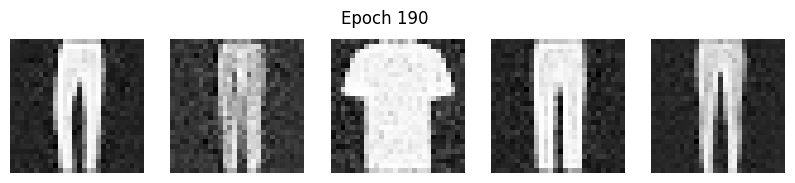

Epoch 191, D Loss: 0.4471851587295532, G Loss: 3.3534421920776367
Epoch 192, D Loss: 0.6857022047042847, G Loss: 1.9538860321044922
Epoch 193, D Loss: 0.3868386149406433, G Loss: 2.127563238143921
Epoch 194, D Loss: 0.591367244720459, G Loss: 2.5697438716888428
Epoch 195, D Loss: 0.4496127963066101, G Loss: 2.047267436981201


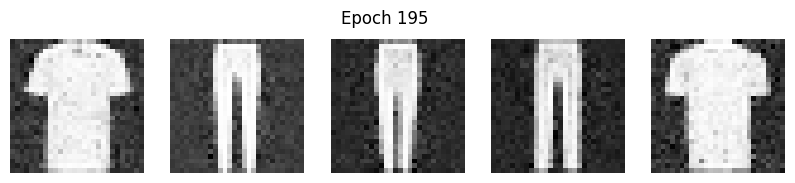

Epoch 196, D Loss: 0.939123272895813, G Loss: 3.8054001331329346
Epoch 197, D Loss: 0.5679357647895813, G Loss: 2.69551944732666
Epoch 198, D Loss: 0.3870052099227905, G Loss: 3.2891225814819336
Epoch 199, D Loss: 0.5080645084381104, G Loss: 1.4819045066833496
Epoch 200, D Loss: 0.5097808837890625, G Loss: 2.404428005218506


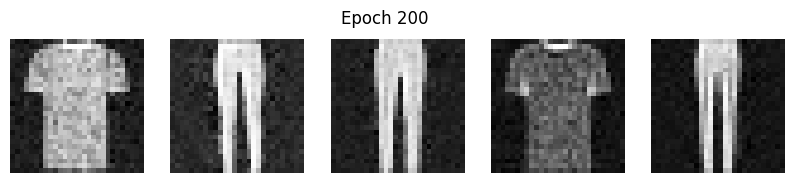

In [ ]:
train(train_dataset, epochs=200)

# FID

FID adalah metrik yang kuat untuk mengevaluasi kualitas gambar yang dihasilkan oleh model generatif. Ini mengukur jarak antara distribusi fitur gambar nyata dan gambar yang dihasilkan, dengan mempertimbangkan perbedaan mean dan kovariansi dari distribusi tersebut. Nilai FID yang lebih rendah menunjukkan bahwa gambar yang dihasilkan lebih mirip dengan gambar nyata.

## FID (berdasarkan vektor piksel)

In [ ]:
import numpy as np
from scipy.linalg import sqrtm

def compute_fid(real_imgs, fake_imgs):
    # Flatten image ke vektor
    real_imgs_flat = real_imgs.reshape((real_imgs.shape[0], -1))
    fake_imgs_flat = fake_imgs.reshape((fake_imgs.shape[0], -1))

    mean_real = np.mean(real_imgs_flat, axis=0)
    cov_real = np.cov(real_imgs_flat, rowvar=False)
    mean_fake = np.mean(fake_imgs_flat, axis=0)
    cov_fake = np.cov(fake_imgs_flat, rowvar=False)

    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real.dot(cov_fake))

    # Handling imaginary valuess
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value

In [ ]:
noise_vector = np.random.normal(0, 1, (test_images_selected.shape[0], latent_dim))
fake_labels = test_labels_selected
fake_images = generator.predict(combine_noise_and_labels(noise_vector, fake_labels, num_classes), verbose=0)

In [ ]:
# Menghitung nilai FID
fid_score = compute_fid(test_images_selected, fake_images)
print(f'FID: {fid_score}')

FID: 9.885926466425724


## FID (berdasarkan fitur pre-trained model InceptionV3)

In [ ]:
def compute_fid_2(real_features, fake_features):
    mean_real = np.mean(real_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    mean_fake = np.mean(fake_features, axis=0)
    cov_fake = np.cov(fake_features, rowvar=False)

    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real.dot(cov_fake))

    # Handling imaginary values
    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value

# Mengubah gambar grayscale menjadi RGB
def to_rgb(images):
    return np.repeat(images, 3, axis=-1)

# Mengubah ukuran gambar ke ukuran input InceptionV3 dan mengubah menjadi RGB dalam batch
def get_features(images, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_resized = tf.image.resize(batch, (299, 299))
        batch_rgb = to_rgb(batch_resized)
        batch_preprocessed = preprocess_input(batch_rgb)
        batch_features = inception_model.predict(batch_preprocessed)
        features.append(batch_features)
    return np.concatenate(features, axis=0)

In [ ]:
# Load InceptionV3 model tanpa top layer
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

In [ ]:
real_features = get_features(test_images_selected)
fake_features = get_features(fake_images)

fid_score_2 = compute_fid_2(real_features, fake_features)
print(f'FID: {fid_score_2}')

1/1 [==============================] - 0s 41ms/step
FID: 0.19446185529309828


# EXPLANATION

**Interpretasi Nilai FID:**
- FID (Fréchet Inception Distance) mengukur kesamaan antara dua set gambar. Nilai lebih rendah berarti gambar palsu lebih mirip dengan gambar nyata.

- Vektor Piksel: FID sebesar 9.885926466425724 menunjukkan distribusi piksel gambar palsu cukup mirip dengan gambar nyata, tetapi ini mungkin tidak mencerminkan kesamaan visual sepenuhnya.

- InceptionV3: FID sebesar 0.19446185529309828 menunjukkan gambar palsu sangat mirip dengan gambar nyata dalam hal distribusi fitur tingkat tinggi. Ini menunjukkan generator menghasilkan gambar yang hampir tidak dapat dibedakan dari gambar nyata.

- Perbandingan: FID di bawah 10 dianggap baik. Nilai FID yang jauh lebih rendah dengan InceptionV3 menunjukkan perbandingan menggunakan fitur tingkat tinggi memberikan gambaran lebih akurat tentang kesamaan visual.

## Screen Shoot Perbandingan (ACAK)

Di Epoch ke-5:

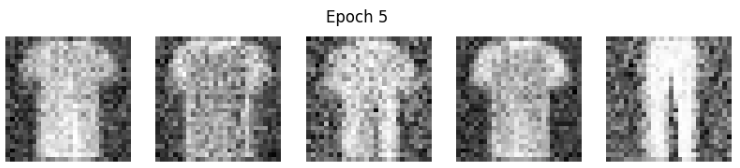

Di Epoch ke-200:

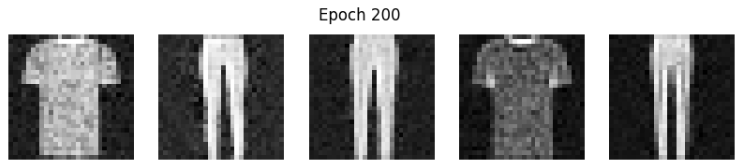

Real-Image

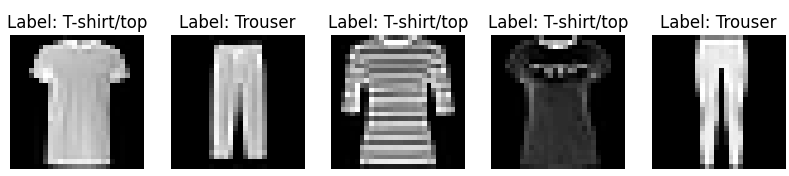

1. Baris Pertama (Epoch 5):
- Gambar pada baris pertama menunjukkan hasil dari generator setelah 5 epoch pelatihan.
- Gambar-gambar ini masih sangat kabur dan tidak jelas. Bentuk dasar dari objek seperti T-shirt/top dan Trouser dapat dilihat, tetapi detail dan kejelasan masih sangat kurang.
- Ini menunjukkan bahwa pada tahap awal pelatihan, generator masih belajar menghasilkan pola dasar dari gambar yang diinginkan.

2. Baris Kedua (Epoch 200):
- Gambar pada baris kedua menunjukkan hasil dari generator setelah 100 epoch pelatihan.
- Gambar-gambar ini lebih jelas dibandingkan dengan hasil setelah 5 epoch. Bentuk dari T-shirt/top dan Trouser lebih terdefinisi, dan beberapa detail mulai muncul.
- Ini menunjukkan kemajuan yang signifikan dalam kemampuan generator untuk menghasilkan gambar yang lebih realistis seiring dengan bertambahnya jumlah epoch pelatihan.

3. Baris Ketiga (Gambar Asli):
- Gambar pada baris ketiga adalah gambar asli dari dataset, dengan label yang sesuai.
- Gambar-gambar ini sangat jelas dan terdefinisi dengan baik, menunjukkan T-shirt/top dan Trouser dengan detail yang sempurna.
- Gambar asli ini digunakan oleh discriminator untuk membedakan antara gambar nyata dan gambar palsu yang dihasilkan oleh generator.

# KESIMPULAN

1. Kemajuan Pelatihan:
- Dari Epoch 1 sampai 200, terlihat jelas bahwa generator menjadi lebih baik dalam menghasilkan gambar yang lebih realistis seiring dengan bertambahnya jumlah epoch pelatihan. Ini menunjukkan bahwa model GAN belajar
dan meningkatkan kualitas hasilnya seiring waktu.

2. Perbandingan dengan Gambar Asli:
- Gambar pada baris ketiga berfungsi sebagai referensi atau target akhir yang diinginkan. Meskipun hasil setelah 200 epoch masih belum sempurna seperti gambar asli, terlihat ada kemajuan yang signifikan dari epoch 5 ke epoch 200.

3. Evaluasi Kualitas:
- Dengan menggunakan Fréchet Inception Distance (FID), didapatkan nilai yang mengukur seberapa mirip distribusi gambar palsu dengan gambar asli.
- Nilai FID berdasarkan vektor piksel adalah 9.885926466425724, menunjukkan distribusi piksel gambar palsu cukup mirip dengan gambar nyata, tetapi mungkin tidak mencerminkan kesamaan visual sepenuhnya.
- Nilai FID berdasarkan fitur InceptionV3 adalah 0.19446185529309828, menunjukkan gambar palsu sangat mirip dengan gambar nyata dalam hal distribusi fitur tingkat tinggi. Ini menunjukkan bahwa generator berhasil menghasilkan gambar yang hampir tidak dapat dibedakan dari gambar nyata.

Gambar ini dengan jelas menunjukkan bagaimana model GAN belajar dan meningkatkan kemampuannya dalam menghasilkan gambar yang realistis dengan bertambahnya jumlah epoch pelatihan. Ini memberikan wawasan visual yang baik tentang proses pelatihan model dan kesamaan visual antara gambar palsu dan nyata berdasarkan metrik FID.

FOLDER VIDEO:

https://drive.google.com/drive/folders/1xqjdupi1iiNEGL7FXW0lVIbF4yBO-Yap?usp=drive_link

LINK CODE NO 1 (COLLAB):

https://colab.research.google.com/drive/1-mf7uwgtoidDlSb9HvNN6yhmnyD9Uent#scrollTo=3DJpZU9B1xMo

LINK CODE NO 2 (COLLAB):

https://colab.research.google.com/drive/1m-zM99EvRIIzz1Pmh_eXewD0yLtoi9fO#scrollTo=LQjAJ3GZ8S1w

LINK CODE NO 3 (COLLAB):

https://colab.research.google.com/drive/1AqZXrCweHM1jTqAxYJnP7B-zHojKVQ1I#scrollTo=Rh5_uFY1yG9H